# Stochastic Variational inference for Gaussian Process Regression

In [1]:
import time
from IPython.display import clear_output

import jax
import jax.numpy as jnp
from jax.experimental import optimizers

from gpjax.kernels import SquaredExponential
from gpjax.mean_functions import Zero
from gpjax.likelihoods import Gaussian
from gpjax.models import SVGP
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(10)

Let's create a simple dataset.

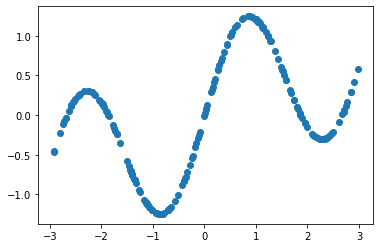

In [2]:
# create some dummy data
input_dim = 1
output_dim = 1
num_data = 200
num_test = 1000
num_inducing = 30

def func(X):
    return jnp.sin(2*X)+ 0.3 * X
X = jax.random.uniform(key, shape=(num_data, input_dim),minval=-3, maxval=3)
Y = func(X)

plt.scatter(X[:,0], Y[:,0])
plt.show()

And some test inputs for plotting our GP.

In [3]:
Xtest = jax.random.uniform(key, shape=(num_test, input_dim),minval=-5, maxval=5)
Xtest = jnp.sort(Xtest, 0)

Create an instance of the SE kernel

In [4]:
kernel = SquaredExponential()
kernel_params = kernel.get_params()  # get the dictionary of parameters associated with kernel
print(kernel_params)

{'lengthscales': DeviceArray([1.], dtype=float64), 'variance': DeviceArray(1., dtype=float64)}


In [5]:
mean_function = Zero(output_dim=output_dim)
likelihood = Gaussian(variance=3.0)
kernel = SquaredExponential(lengthscales=jnp.ones(input_dim, dtype=jnp.float64), variance=2.0)

In [6]:
inducing_variable = jax.random.uniform(key=key, shape=(num_inducing, input_dim))
svgp = SVGP(kernel, likelihood, inducing_variable, mean_function, num_latent_gps=output_dim)
svgp_params = svgp.get_params()
print(svgp_params.keys())

dict_keys(['kernel', 'likelihood', 'mean_function', 'inducing_variable', 'q_mu', 'q_sqrt'])


insidce single output cond
(30, 30)
(30, 1)
Kmn
(30, 1000)
(1000,)
base before A
(30, 30)
(1000,)


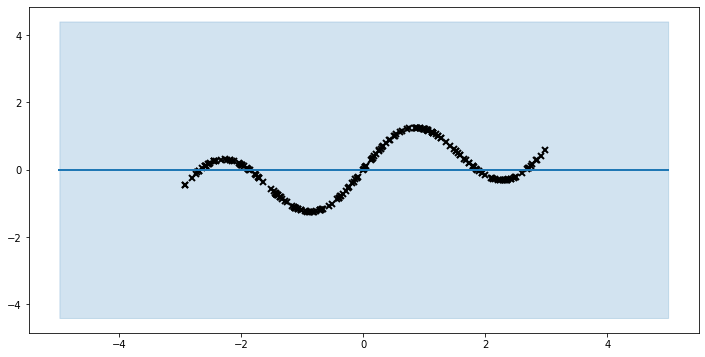

In [7]:
def plot_model(params):
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, "kx", mew=2)
    mean, var = svgp.predict_y(params, Xtest, full_cov=False)
    plt.plot(Xtest, mean, "C0", lw=2)
    plt.fill_between(
        Xtest[:, 0],
        mean[:, 0] - 1.96 * jnp.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * jnp.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )
    plt.show()
plot_model(svgp_params)

In [8]:
learning_rate = 1e-3
batch = (X, Y)
num_epochs = 10000

# Create optimizer
opt_init, opt_update, get_params = optimizers.adam(learning_rate)

In [13]:
@jax.jit
def compute_loss(params, batch):
    X, Y = batch
    return -svgp.elbo(params, X, Y)

@jax.jit
def train_step(step_i, opt_state, batch):
    params = get_params(opt_state)
    loss = compute_loss(params, batch)
    grads = jax.grad(compute_loss, argnums=0)(params, batch)
    return loss, opt_update(step_i, grads, opt_state)

In [14]:
opt_state = opt_init(svgp_params)

In [15]:
loss_history = []
for i in range(num_epochs):
#     x = sample_batch(size=128)
    loss, opt_state = train_step(i, opt_state, batch)
    params = get_params(opt_state)
#     if params['kernel']['variance'] < 0:
#         print('var is negarive')
#     if jnp.any(params['kernel']['lengthscales'] < 0):
#         print('lengthscales is negarive')
#     if jnp.any(params['q_sqrt'] < 0):
#         print('q_sqrt is negarive')
    loss_history.append(loss.item())
    
#     if i % 200 == 0:
#         clear_output(True)
#         plt.figure(figsize=[16, 8])
#         plt.subplot(1, 2, 1)
#         plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
#         plt.scatter(jnp.arange(len(loss_history)), loss_history)
#         plt.grid()
#         plt.show()

kl
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/2)>
insidce single output cond
(30, 30)
(30, 1)
Kmn
(30, 200)
(200,)
base before A
(30, 30)
(200,)
f_mean
(200, 1)
(200, 1)
var_exp
(200,)
()
kl
Traced<ShapedArray(float64[])>with<JVPTrace(level=2/2)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/2)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/2)>
insidce single output cond
(30, 30)
(30, 1)
Kmn
(30, 200)
(200,)
base before A
(30, 30)
(200,)
f_mean
(200, 1)
(200, 1)
var_exp
(200,)
()
kl
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/2)>
insidce single output cond
(30, 30)
(30, 1)
Kmn
(30, 200)
(200,)
base before A
(30, 30)
(200,)
f_mean
(200, 1)
(200, 1)
var_exp
(200,)
()
kl
Traced<ShapedArray(float64[])>with<JVPTrace(level=2/2)>
  with primal = Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/2)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=1/2)>
insidce single output cond
(30

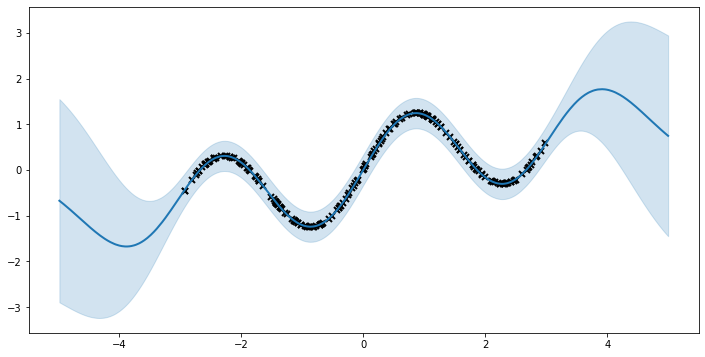

{'lengthscales': DeviceArray([1.08538694], dtype=float64), 'variance': DeviceArray(1.36212459, dtype=float64)}


In [16]:
params = get_params(opt_state)
plot_model(params)
print(params['kernel'])